# Exercise 2 - Group 4
- Matthias Egli
- Florian Bär
- Manuel Vogel
- Adrian Willi

In [1]:
import os 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### a) Read lexicons

In [3]:
def read_vocabulary_from_file(filename):
    with open(filename , 'r', encoding="ISO-8859-1") as f:
        content = f.readlines() # content is a list of lines
        content = [x.strip() for x in content] # removing newline chars
        content = [x for x in content if x != ""] # remove empty words
        content = [x for x in content if x[0] not in [';', '+']] # remove invalid words
        content = [x for x in content if x[-1] not in [';', '+']] # remove invalid words

        return content

In [10]:
pos_words = read_vocabulary_from_file("opinion-lexicon-English/positive-words.txt")
neg_words = read_vocabulary_from_file("opinion-lexicon-English/negative-words.txt")

assert len(pos_words) == 2005
assert len(neg_words) == 4783

### b) Convert words into vectors

In [11]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path , 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors
    return embeddings

In [21]:
word_dict = load_glove_embeddings('glove.6B.50d.txt/glove.6B.50d.txt')
print("Size of embedding: ", len(word_dict))
word = 'happy'
print("Emedding for ", word, ":\n", word_dict[word])

Size of embedding:  400000
Emedding for  happy :
 [ 0.092086  0.2571   -0.58693  -0.37029   1.0828   -0.55466  -0.78142
  0.58696  -0.58714   0.46318  -0.11267   0.2606   -0.26928  -0.072466
  1.247     0.30571   0.56731   0.30509  -0.050312 -0.64443  -0.54513
  0.86429   0.20914   0.56334   1.1228   -1.0516   -0.78105   0.29656
  0.7261   -0.61392   2.4225    1.0142   -0.17753   0.4147   -0.12966
 -0.47064   0.3807    0.16309  -0.323    -0.77899  -0.42473  -0.30826
 -0.42242   0.055069  0.38267   0.037415 -0.4302   -0.39442   0.10511
  0.87286 ]


### c) Prepare the training and testing sets

In [22]:
pos_word_embeddings = np.array([word_dict[w] for w in pos_words if w in word_dict])
neg_word_embeddings = np.array([word_dict[w] for w in neg_words if w in word_dict])

print("positive word embeddings: ", pos_word_embeddings.shape)
print("negative word embeddings: ", neg_word_embeddings.shape)

positive word embeddings:  (1893, 50)
negative word embeddings:  (4345, 50)


In [30]:
n = 1500

X_train = np.concatenate((pos_word_embeddings[:n], neg_word_embeddings[:n]), axis=0)
X_test = np.concatenate((pos_word_embeddings[n:], neg_word_embeddings[n:]), axis=0)

y_train = np.concatenate((np.ones(n), np.zeros(n)))
y_test = np.concatenate((np.ones(pos_word_embeddings[n:].shape[0]),
                         np.zeros(neg_word_embeddings[n:].shape[0])))

train_indices = np.random.permutation(X_train.shape[0])
test_indices = np.random.permutation(X_test.shape[0])

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (3000, 50) y_train: (3000,)
X_test: (3238, 50) y_test: (3238,)


### d) Train and evaluate a classifier

In [31]:
keras = tf.keras

model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=keras.optimizers.Adam(lr=0.001))

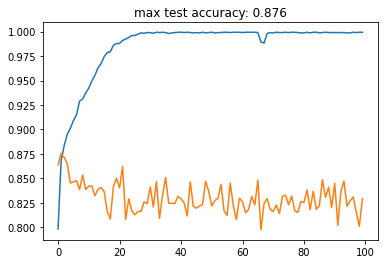

In [32]:
log = model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0, validation_data=(X_test, y_test))

plt.plot(log.history["accuracy"])
plt.plot(log.history["val_accuracy"])
plt.title(f"max test accuracy: {round(max(log.history['val_accuracy']), 3)}")
plt.show()

### e) Analysis of results and discussions.

In [34]:
pos_words_test = [w for w in pos_words if w in word_dict]
neg_words_test = [w for w in neg_words if w in word_dict]
pos_words_test = [w for w in pos_words_test if pos_words_test.index(w) >= n]
neg_words_test = [w for w in neg_words_test if neg_words_test.index(w) >= n]

print("positive test words:", len(pos_words_test), "negative test words:", len(neg_words_test))

test_words = pos_words_test + neg_words_test
print("total test words:", len(test_words))

positive test words: 393 negative test words: 2845
total test words: 3238


In [35]:
test_pred = model.predict(X_test)
test_word_predictions = [(test_words[i], y_test[i], test_pred[i][0]) for i in range(X_test.shape[0])]

In [36]:
pos_sorted = sorted(test_word_predictions, key=lambda x: x[-1], reverse=True)[:5]
neg_sorted = sorted(test_word_predictions, key=lambda x: x[-1], reverse=False)[:5]

for w, l, p in pos_sorted + neg_sorted:
    print(w)
    print("(", "positive" if l == 1 else "negative", ", prob=", round(p, 3), ")")
    print()

serene
( positive , prob= 1.0 )

simpler
( positive , prob= 1.0 )

sociable
( positive , prob= 1.0 )

spectacularly
( positive , prob= 1.0 )

strong
( positive , prob= 1.0 )

overdue
( negative , prob= 0.0 )

shrill
( negative , prob= 0.0 )

zaps
( negative , prob= 0.0 )

tortures
( negative , prob= 0.0 )

misaligned
( negative , prob= 0.0 )



Both the negative and positive words are reasonable.

In [37]:
unsure = sorted(test_word_predictions, key=lambda x: abs(0.5 - x[-1]), reverse=False)[:5]

for w, l, p in unsure:
    print(w)
    print("(", "positive" if l == 1 else "negative", ", prob=", round(p, 3), ")")
    print()

misuse
( negative , prob= 0.5 )

veritable
( positive , prob= 0.501 )

pervert
( negative , prob= 0.496 )

upset
( negative , prob= 0.492 )

miscreant
( negative , prob= 0.491 )



While some of the words have a clear negative meaning to me like misuse or upset have others like veritable a less clear meaning.